Grabbing all threads from subreddits

r/Cryptocurrency
r/Stocks

# Problem Statement: 

- Using Pushshift's API, collect posts from r/Cryptocurrency and r/Stocks
- Use NLP to train a binary classifier on which subreddit a given post came from

In [26]:
# Imports
import requests
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from nltk.stem import WordNetLemmatizer

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Using Pushshift's API, you'll collect posts from two subreddits of your choosing.

In [2]:
def reddit(subreddit, size, number_of_pulls):
    
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit':subreddit,
        'size':size
    }
    # Let last_utc = None so first loop pulls most recent posts
    last_utc = None   
    # Empty list to append dataframes to
    dfs = []
    # For loop to have multiple pulls
    for i in range(number_of_pulls):
          params['before'] = last_utc
          print(params['before'])
          res = requests.get(url, params)
          if res.status_code == 200:
              data = res.json()
              posts = data['data']
              df = pd.DataFrame(posts)
          last_utc = df['created_utc'].min()

          # Add the dataframe collected from this pull to dfs
          dfs.append(df)
    # Concatenate all dataframes together! (While dropping duplicates)
    full_df = pd.concat(dfs).drop_duplicates(subset = 'title')
    return full_df

In [3]:
crypto_df = reddit('cryptocurrency', 1000, 5)

None
1678633221
1678494682
1678376134
1678240394


In [4]:
crypto_df.shape

(4621, 95)

In [5]:
stock_df = reddit('stocks', 1000, 5)

None
1677655310
1676318895
1675216809
1674086631


In [6]:
stock_df.shape

(4759, 93)

# Data Cleaning!

In [7]:
# dropping the 'u/Dont-know-stocks'
stock_df = stock_df[stock_df['subreddit_name_prefixed'].str.contains("u/Dont-know-stocks") == False]

In [8]:
stock_df.columns

Index(['subreddit', 'selftext', 'author_fullname', 'gilded', 'title',
       'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls',
       'link_flair_css_class', 'thumbnail_height', 'top_awarded_type',
       'hide_score', 'quarantine', 'link_flair_text_color', 'upvote_ratio',
       'author_flair_background_color', 'subreddit_type',
       'total_awards_received', 'media_embed', 'thumbnail_width',
       'author_flair_template_id', 'is_original_content', 'secure_media',
       'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed',
       'link_flair_text', 'score', 'is_created_from_ads_ui', 'author_premium',
       'thumbnail', 'edited', 'author_flair_css_class',
       'author_flair_richtext', 'gildings', 'content_categories', 'is_self',
       'link_flair_type', 'wls', 'removed_by_category', 'author_flair_type',
       'domain', 'allow_live_comments', 'suggested_sort', 'view_count',
       'archived', 'no_follow', 'is_crosspostable', 'pinned', 'over_18'

In [9]:
df = pd.concat([crypto_df, stock_df])

In [10]:
df = df[['subreddit_name_prefixed', 'title']]

In [11]:
df.rename(columns = {'subreddit_name_prefixed':'subreddit'}, inplace = True)

In [12]:
# Create label column
df['subreddit'] = df['subreddit'].map({'r/CryptoCurrency': 0, 'r/stocks': 1})

In [13]:
df['subreddit'].value_counts(normalize = True)

1.0    0.507198
0.0    0.492802
Name: subreddit, dtype: float64

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(9379, 2)

In [16]:
df.head()

,subreddit,title
0,0.0,"BlockFi in no immediate danger, despite Silico..."
1,0.0,"18.000 Btc Moved to Binance from a Wallet, Wha..."
2,0.0,"Global economy, standard of living, rents, pri..."
3,0.0,"18.000 BTC moved to Binance, what to expect?"
4,0.0,OSFI seizes control of Silicon Valley Bank's C...


In [17]:
df.dropna(inplace = True)

In [18]:
df.isnull().sum()

subreddit    0
title        0
dtype: int64

# Lemmatize

In [19]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    words = text.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words   

In [20]:
df['title'] = df['title'].apply(lemmatize_words)

In [21]:
df.shape

(9377, 2)

# Count Vectorizer

In [22]:
count_vect = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = "english", 
                             max_features = 30) 
vector_input_crypto = df[df['subreddit'] == 0]['title']
crypto_words = count_vect.fit_transform(vector_input_crypto)
crypto_words = crypto_words.toarray()

In [23]:
crypto_words_list = pd.DataFrame(crypto_words, columns = count_vect.get_feature_names())
crypto_words_list.sum().sort_values(ascending=False).head(10)

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


crypto     1122
bitcoin     453
bank        447
usdc        268
market      192
valley      185
silicon     183
new         179
binance     148
svb         140
dtype: int64

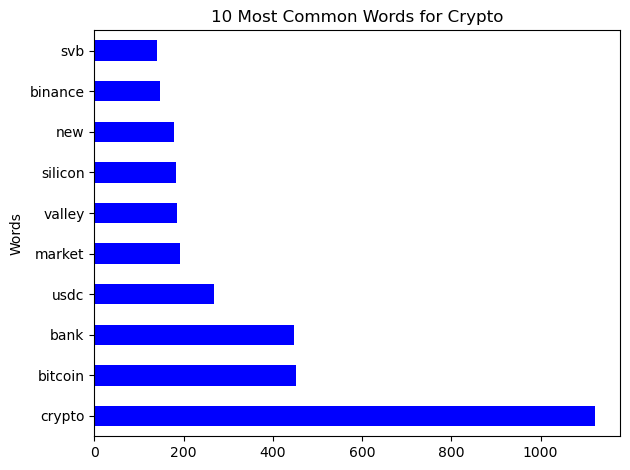

In [36]:
crypto_words_list.sum().sort_values(ascending = False).head(10).plot(kind = 'barh',
                                                                     ylabel = 'Words',
                                                                     title = '10 Most Common Words for Crypto',
                                                                     color = 'blue');
plt.tight_layout()
plt.savefig('images/10_common_crypto.png')

In [30]:
count_vect = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = "english", 
                             max_features = 10) 
vector_input_stock = df[df['subreddit'] == 1]['title']
stock_words = count_vect.fit_transform(vector_input_stock)
stock_words = stock_words.toarray()

In [31]:
stock_words_list = pd.DataFrame(stock_words, columns = count_vect.get_feature_names())
stock_words_list.sum().sort_values(ascending=False).head(30)

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


stock        953
market       337
stocks       295
trading      193
buy          189
2023         180
investing    163
new          147
company      145
amp          142
dtype: int64

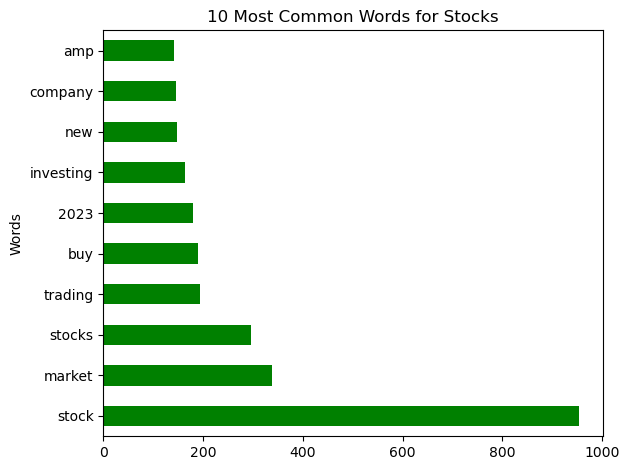

In [37]:
stock_words_list.sum().sort_values(ascending = False).head(10).plot(kind = 'barh',
                                                                     ylabel = 'Words',
                                                                     title = '10 Most Common Words for Stocks',
                                                                     color = 'green');
plt.tight_layout()
plt.savefig('images/10_common_stocks.png')

# TfidfVectorizer

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


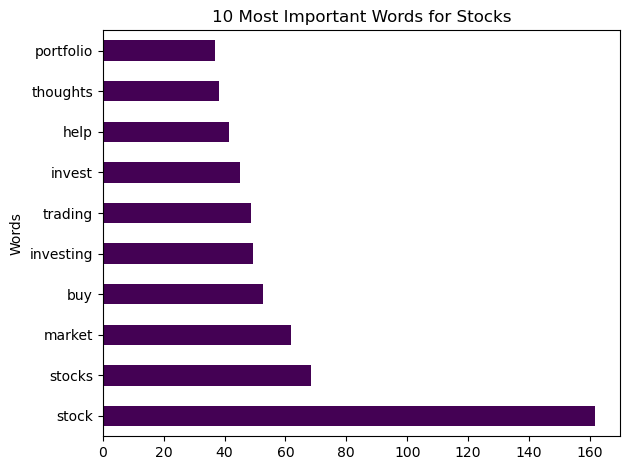

In [38]:
tvec = TfidfVectorizer(analyzer = "word", 
                     stop_words = "english", 
                     max_features = 10000, 
                     ngram_range = (1, 3))

stock_tf_words = tvec.fit_transform(vector_input_stock)
stock_tf_words = stock_tf_words.toarray()
stock_matrix = pd.DataFrame(stock_tf_words, columns=tvec.get_feature_names())
stock_matrix.sum().sort_values(ascending=False).head(10).plot(kind = 'barh',
                                                                     ylabel = 'Words',
                                                                     title = '10 Most Important Words for Stocks',
                                                                     cmap = 'viridis');
plt.tight_layout()
plt.savefig('images/10_import_stocks.png')

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


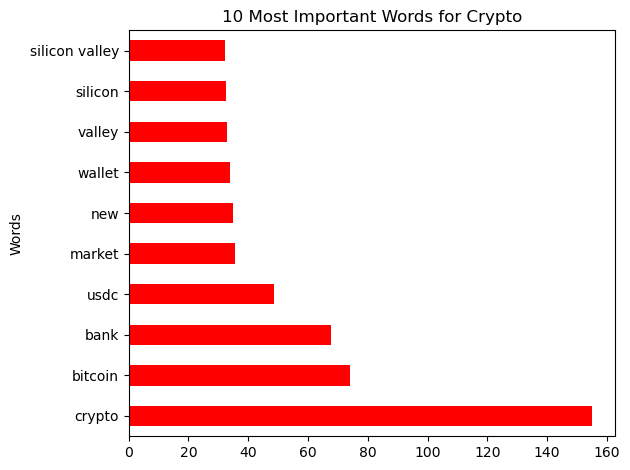

In [39]:
tvec = TfidfVectorizer(analyzer = "word", 
                     stop_words = "english", 
                     max_features = 10000, 
                     ngram_range = (1, 3))

crypto_tf_words = tvec.fit_transform(vector_input_crypto)
crypto_tf_words = crypto_tf_words.toarray()
crypto_matrix = pd.DataFrame(crypto_tf_words, columns=tvec.get_feature_names())
crypto_matrix.sum().sort_values(ascending=False).head(10).plot(kind = 'barh',
                                                                     ylabel = 'Words',
                                                                     title = '10 Most Important Words for Crypto',
                                                                     color = 'red');
plt.tight_layout()
plt.savefig('images/10_import_crypto.png')

# Function to input model

In [196]:
def input_model(dataframe, model):
    
    X = dataframe['title']
    y = dataframe['subreddit']
    
    
    print(f"Baseline: {y.value_counts(normalize = True)}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2023)
    # CVEC PIPELINE
    pipe = Pipeline([('cvec', CountVectorizer()), ('nb', model)])
    pipe_params = {'cvec__max_features': [8_000, 9_000, 10_000],
                    'cvec__min_df': [2, 3],
                    'cvec__max_df': [.9, .95],
                    'cvec__ngram_range': [(1, 1), (1,2), (2,2)]}
    gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)
    gs.fit(X_train, y_train)
    print(f"Best CVEC GS Parameters: {gs.best_params_}")
    print(f"CVEC Training Score: {gs.score(X_train, y_train)}")
    print(f"CVEC Test Score: {gs.score(X_test, y_test)}")
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"Specificity: {tn / (tn + fp)}")
    print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")
    print(plot_confusion_matrix(gs, X_test, y_test, cmap='winter'))
    
    # TVEC PIPELINE
    tpipe = Pipeline([('tvec', TfidfVectorizer()),('nb', model)])
    
    tpipe_params = {
    'tvec__max_features': [5_000, 6_000, 7_000, 8_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1,2), (2,2)]}
    
    tgs = GridSearchCV(tpipe,param_grid = tpipe_params,cv = 5)
    tgs.fit(X_train, y_train)
    
    print(f"TVEC GS Parameters: {tgs.best_params_}")
    print(f"TVEC Training Score: {tgs.score(X_train, y_train)}")
    print(f"TVEC Test Score: {tgs.score(X_test, y_test)}")
    
    preds_tvec = tgs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()
    print(f"Specificity: {tn / (tn + fp)}")
    print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")
    
    print(plot_confusion_matrix(tgs, X_test, y_test, cmap = 'Greens'))

Baseline: 1.0    0.510973
0.0    0.489027
Name: subreddit, dtype: float64
Best CVEC GS Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 8000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
CVEC Training Score: 0.961456102783726
CVEC Test Score: 0.8886986301369864
Specificity: 0.851138353765324
Accuracy: 0.8886986301369864


C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


TVEC GS Parameters: {'tvec__max_features': 6000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
TVEC Training Score: 0.9476088508208422
TVEC Test Score: 0.8891267123287672
Specificity: 0.8669001751313485
Accuracy: 0.8891267123287672


C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


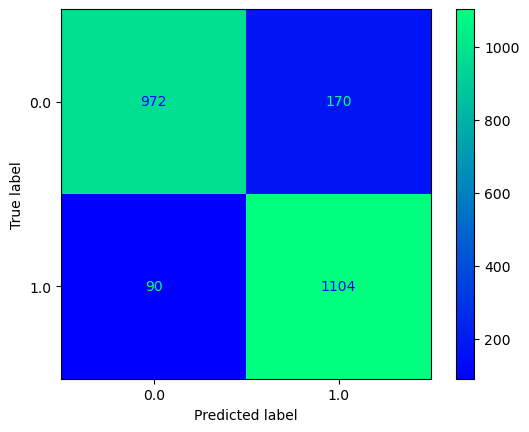

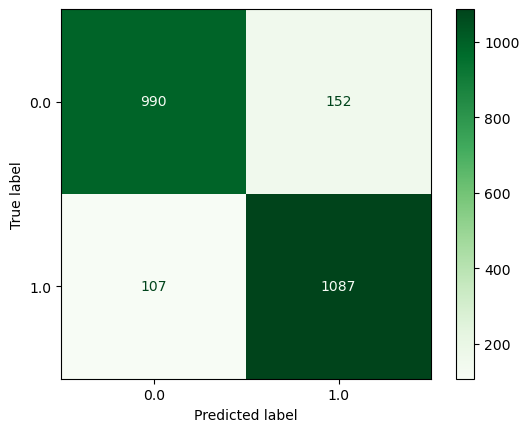

In [197]:
# Logistic Regression
input_model(df, LogisticRegression())

Baseline: 1.0    0.510973
0.0    0.489027
Name: subreddit, dtype: float64


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

Best CVEC GS Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 8000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


CVEC Training Score: 0.8478229835831549


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


CVEC Test Score: 0.7238869863013698


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.6786339754816112
Accuracy: 0.7238869863013698


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

TVEC GS Parameters: {'tvec__max_features': 8000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


TVEC Training Score: 0.6906495360456817


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


TVEC Test Score: 0.5774828767123288


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.9746059544658494
Accuracy: 0.5774828767123288


C:\Users\tu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


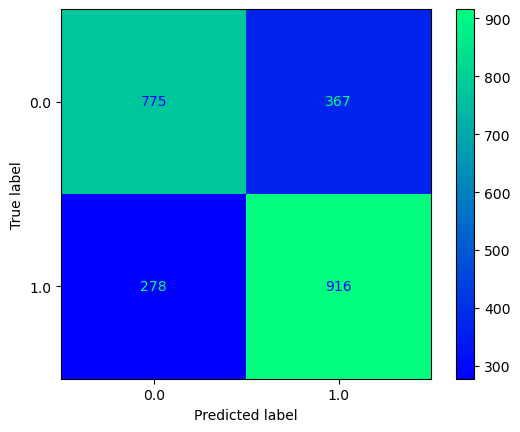

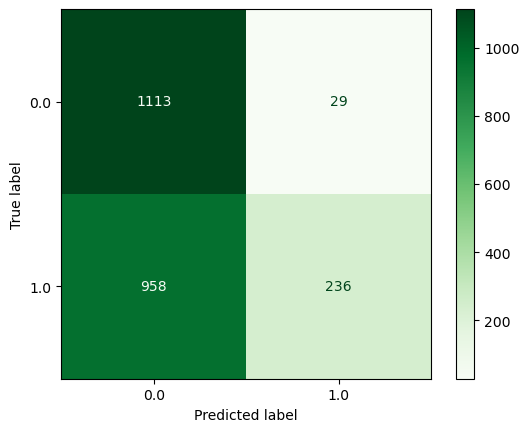

In [198]:
# Knn Classifier
input_model(df, KNeighborsClassifier())

Baseline: 1.0    0.510973
0.0    0.489027
Name: subreddit, dtype: float64
Best CVEC GS Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 8000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
CVEC Training Score: 0.956887937187723
CVEC Test Score: 0.8814212328767124
Specificity: 0.829246935201401
Accuracy: 0.8814212328767124


C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


TVEC GS Parameters: {'tvec__max_features': 8000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
TVEC Training Score: 0.9931477516059957
TVEC Test Score: 0.9032534246575342
Specificity: 0.8879159369527145
Accuracy: 0.9032534246575342


C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


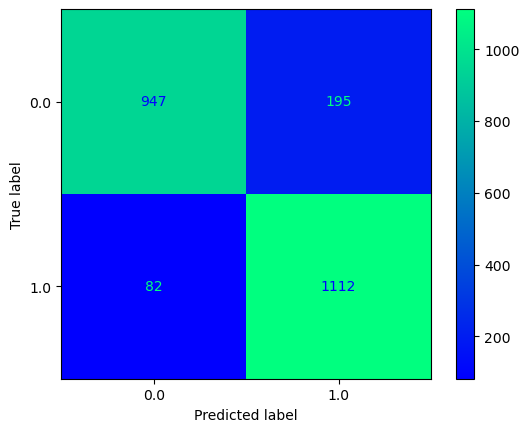

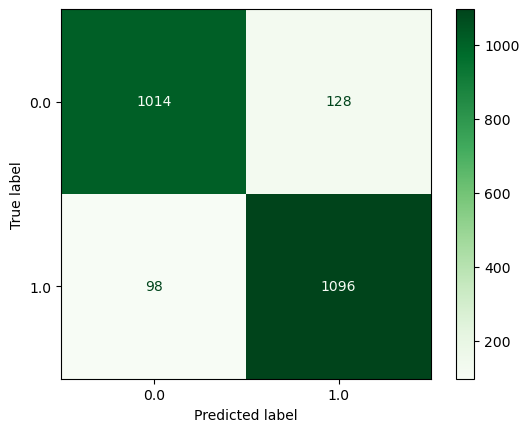

In [199]:
# Support Vector Classifier
input_model(df, SVC())

In [205]:
X = df['title']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2023)

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


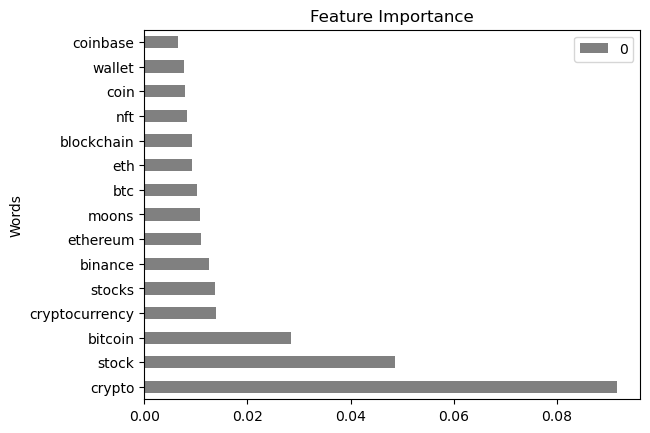

In [210]:
# CVEC words, using Random Forest to find most important features throughout both subreddits

cvec = CountVectorizer(analyzer = "word",                        
                         tokenizer = None, 
                         preprocessor = None,
                         stop_words = "english", 
                         max_features = 10000)
rf = RandomForestClassifier(random_state = 2023)

pipe = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

pipe.fit(X_train, y_train)
rf_features = cvec.get_feature_names()
rf_features_important = rf.feature_importances_

df_rf = pd.DataFrame(data = rf_features_important, index=rf_features)
df_rf.sort_values(by=0, ascending=False).head(15).plot(kind = 'barh',
                                                                     ylabel = 'Words',
                                                                     title = 'Feature Importance',
                                                                     color = 'grey');

## Conclusion:

The best scoring model for this problem is: Support Vector Classifier